### PACKAGE

In [25]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
import sys
sys.path.append('../')

import package_DBR
import package_lab

from importlib import reload
package_DBR = reload (package_DBR)
package_lab = reload(package_lab)

from package_lab import *
from package_DBR import *

### Simulation parameters

In [26]:
TSim = 3000
Ts = 1
N = int(TSim/Ts) + 1

#Optimal approximation of input-output dynamic as a SOPDT process 
Kp = 0.225
T1p = 132.482624
T2p = 0.918240
thetap = 2

#Optimal approximation of disturbance dynamic as a SOPDT process 
Kd = 0.22284855015965102
T1d = 249.1389254239695
T2d = 0.000986734489272344
thetad = 38.6300681845326

Ts = 1

#Operating point parameters
DV0 = 50
MV0 = 50
PV0 = 67

#IMC tunning PID parameters using SOPDT process 
gamma_high = 0.8
Kc, Ti, Td = IMCTuning(Kp, T1p, T2p, thetap, gamma_high, model = "SOPDT")
alpha = 1
PVInit = 39
MVmin = 0
MVmax = 100
print(f"Kc: {Kc}, Ti: {Ti}, Td: {Td}")

#IMC tunning PID parameters using SOPDT process with lower value of gamma (more aggressive)
gamma_low = 0.6
Kc_low_gamma, Ti_low_gamma, Td_low_gamma = IMCTuning(Kp, T1p, T2p, thetap, gamma_low, model = "SOPDT")
print(f"Kc: {Kc_low_gamma}, Ti: {Ti_low_gamma}, Td: {Td_low_gamma}")

Kp : 0.225, Tlag1 : 132.482624, Tlag2 : 0.91824, thetha : 2, Kc : 5.545169990333348, Ti : 133.482624, Td : 0.9925083882078913
Kc: 5.545169990333348, Ti: 133.482624, Td: 0.9925083882078913
Kp : 0.225, Tlag1 : 132.482624, Tlag2 : 0.91824, thetha : 2, Kc : 7.37059564656695, Ti : 133.482624, Td : 0.9925083882078913
Kc: 7.37059564656695, Ti: 133.482624, Td: 0.9925083882078913


### Simulation Input Signals

In [27]:
scenario = "CLP+FF"

# Scenario 1 : OLP + no FF
if scenario == "OLP+noFF":
    ManPath = {0:True, TSim: True}
    MVManPath = {0:MV0, TSim: MV0}
    SPPath = {0:PV0, TSim: PV0}
    DVPath = {0: 50.0, 1100: 60, TSim: 60.0}
    ActivateFF = False
    ManFF = True

    
# Scenaro 2 : OLP + FF
elif scenario == "OLP+FF":
    ManPath = {0:True, TSim: True}
    MVManPath = {0:MV0, TSim: MV0}
    SPPath = {0:PV0, TSim: PV0}
    DVPath = {0: 50.0, 1000: 60, TSim: 60.0}
    ActivateFF = True
    ManFF = True

# Scenaro 3 : CLP + no FF
elif scenario == "CLP+noFF":
    ManPath = {0:True, 500:False, TSim: False}
    MVManPath = {0:MV0, TSim: MV0}
    SPPath = {0: PV0+5, 1200: PV0-5, TSim: PV0-5}
    DVPath = {0: DV0, 2000: DV0+10, TSim: DV0+10}
    ActivateFF = False
    ManFF = False

# Scenaro 4 : CLP + FF
elif scenario == "CLP+FF":
    ManPath = {0:True, 500:False, TSim: False}
    MVManPath = {0:MV0, TSim: MV0}
    SPPath = {0: PV0+5, 1000: PV0-5, TSim: PV0-5}
    DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10}
    ActivateFF = True
    ManFF = False

### Closed-loop simulation with PID and FF

In [28]:
#Initialization of arrays for time series and process data
t, SP, MV, Man, MVMan = [], [], [], [], []
MVFF, MVP, MVI, MVD, DV, PV, E = [], [], [], [], [], [], []
MVFFDelay, MVFFLL1, MVDelayp, PV1p, PV2p = [], [], [], [], []
MVDelayd, PV1d, PV2d = [], [], []
MVMin = 0  # Define MVMin and assign a value
MVMax = 100

#Populate the time array with sampling instances
for index in range(0, N):
    t.append(index * Ts)

    #Handling inputs for setpoint (SP) and disturbance (DV)
    #The functions 'SelectPath_RT' dynamically choose the path of SP and DV based on time
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(DVPath, t, DV)
    
    #Feedforward component calculation
    #Applying delays and lead-lag compensators according to control scheme
    Delay_RT(DV - DV0 * np.ones_like(DV), max(thetad - thetap, 0), Ts, MVFFDelay)
    LeadLag_RT(MVFFDelay, -Kd/Kp, T1p, T1d, Ts, MVFFLL1)
    if ActivateFF:
        LeadLag_RT(MVFFLL1, 1, T2p, T2d, Ts, MVFF)
    else:
        LeadLag_RT(MVFFLL1, 0, T2p, T2d, Ts, MVFF)
    
    #PID control action
    #Engaging manual path selection and MV manual path
    SelectPath_RT(ManPath, t, Man)
    SelectPath_RT(MVManPath, t, MVMan)
    PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF=False, PVInit=PV0, method='EBD-EBD')
    
    #Input-output dynamics represented by P(s) involving delay and two first-order processes
    Delay_RT(MV, thetap, Ts, MVDelayp, MV0)
    FO_RT(MVDelayp, Kp, T1p, Ts, PV1p, 0)
    FO_RT(PV1p, 1, T2p, Ts, PV2p, 0)
    
    #Disturbance dynamics characterized by D(s) with delay and two first-order processes
    Delay_RT(DV - DV0 * np.ones_like(DV), thetad, Ts, MVDelayd, 0)
    FO_RT(MVDelayd, Kd, T1d, Ts, PV1d, 0)
    FO_RT(PV1d, 1, T2d, Ts, PV2d, 0)
    
    #Final Process Value (PV) computation combining the output of input and disturbance dynamics
    PV.append(PV2p[-1] + PV2d[-1] + PV0 - Kp * MV0)  # PV0: Steady state output for MV=0

### Plot

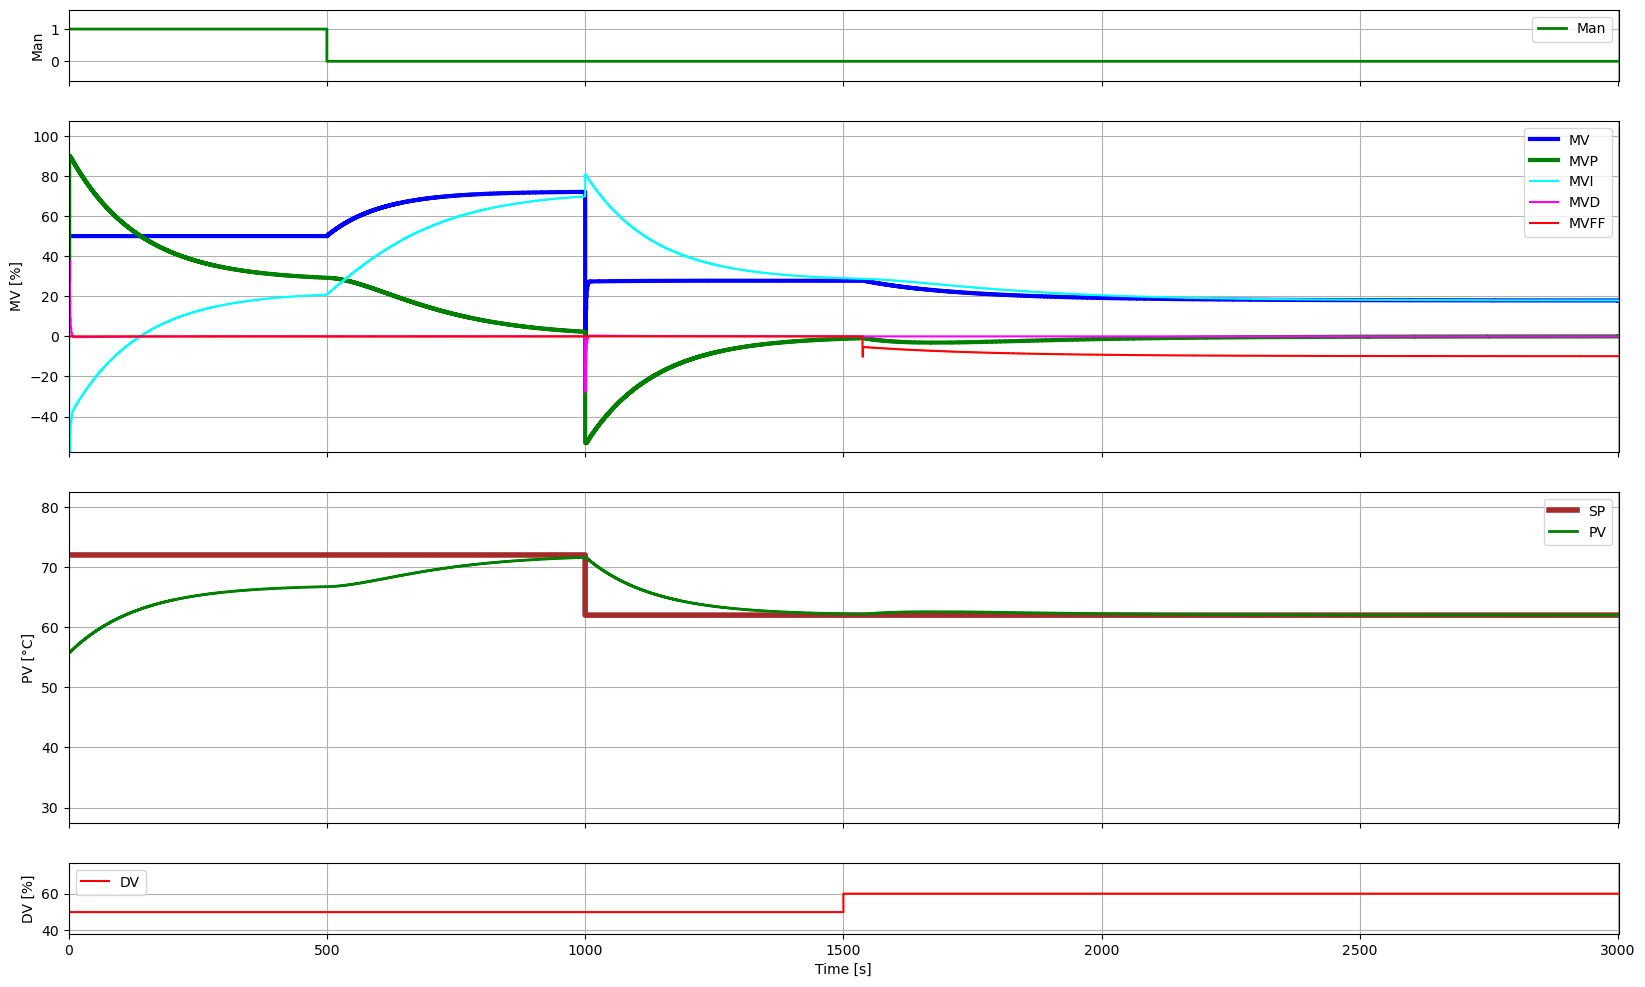

In [29]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4,ncols=1, sharex='col', gridspec_kw={'height_ratios': [1.5, 7, 7, 1.5]})
fig.set_figheight(12)
fig.set_figwidth(20)



#------MAN--------
limSup = 1.5
limInf = -0.5
l1, = ax1.step([0,TSim], [limInf,limSup], 'green',linewidth=2, label='Man', where="post")
ax1.set_ylabel('Man')
ax1.legend (loc='best')

#-------MV_MVP_MVI_MVD_MVFF--------------
limSup = 100
limInf = -50
l2, = ax2.step([0, TSim], [limInf,limSup], 'blue', linewidth=3, label='MV', where='post') 
l3, = ax2.step([0, TSim], [limInf,limSup], 'green', linewidth=3, label='MVP', where='post') 
l4, = ax2.step([0, TSim], [limInf,limSup], 'cyan', label='MVI', where='post')
l5, = ax2.step([0, TSim], [limInf,limSup], 'magenta', label='MVD', where='post')
l6, = ax2.step([0, TSim], [limInf,limSup], 'red', label='MVFF', where='post') 
ax2.set_ylabel('MV [%]')
ax2.legend (loc='best')


#----SP_and_PV---------
limSup = 80
limInf = 30
l7, = ax3.step([0, TSim], [limInf,limSup], 'brown', linewidth=4, label='SP', where="post")
l8, = ax3.step([0, TSim], [limInf,limSup], 'green', linewidth=2, label='PV', where='post')
ax3.set_ylabel('PV [°C]')
ax3.legend (loc='best')

#-------DV-------------
limSup=75
limInf = 40
l9, = ax4.step([0, TSim], [limInf,limSup], 'red', label='DV', where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('DV [%]')
ax4.legend (loc='best')


#-----Set Data-----
l1.set_data(t, Man)
l2.set_data(t,MV)
l3.set_data(t, MVP)
l4.set_data(t,MVI)
l5.set_data(t, MVD)
l6.set_data(t, MVFF)
l7.set_data(t, SP)
l8.set_data(t, PV)
l9.set_data(t, DV)

tMax = len(t)
ax1.set_xlim(0, tMax)
ax2.set_xlim(0, tMax)
ax3.set_xlim(0, tMax)
ax4.set_xlim(0, tMax)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

